In [0]:
!pip install tf-nightly-2.0-preview


     |█████████████▉                  | 41.1MB 2.7MB/s eta 0:00:21

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

tf.enable_eager_execution()

1.15.0-rc3


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

for x, y in dataset:
  print(x.numpy().shape)
  print(y.numpy().shape)
  print(x.numpy()[:3])
  print(y.numpy()[:3])
  break

(32, 20)
(32,)
[[25.61978  28.487524 35.054302 20.683037 33.692867 27.943205 22.999773
  30.233395 28.934015 24.953756 28.320253 26.06135  28.57245  31.332735
  35.969654 21.868246 38.740505 18.333178 27.353228 31.072536]
 [50.67116  40.81647  49.086952 53.619343 34.027466 42.37602  49.22129
  45.29673  48.144333 43.245922 46.676632 45.44373  52.040035 47.452827
  47.84891  44.082253 43.68492  43.942028 48.05951  43.965313]
 [30.84493  25.66792  30.18544  30.446434 25.366972 38.226013 31.225473
  22.859697 32.05963  23.864828 32.63576  34.45614  24.523287 33.40782
  30.619787 32.631824 37.97182  27.227936 24.653889 23.943367]]
[29.55496  47.50264  24.280926]


In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


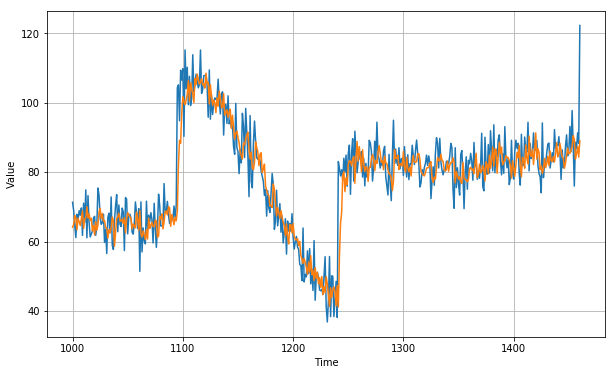

In [14]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis])) # (n, 1, 1)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0] # (n, )


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.937278

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.001, 0, 300]

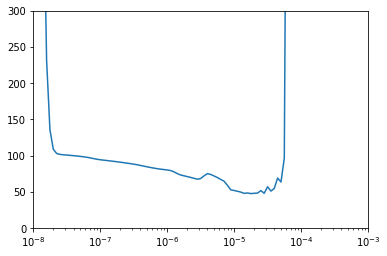

In [17]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [18]:
import numpy as np
np.min(history.history["loss"]), np.argmin(history.history["loss"])

(47.47586722860531, 65)

In [19]:
1e-8 * (10 ** (64 / 20))

1.584893192461114e-05

In [0]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1.585e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

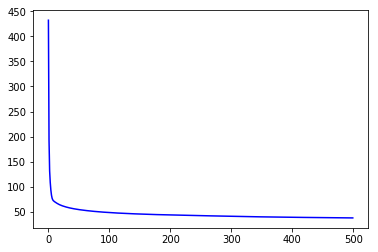

In [21]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[70.15679890740778, 69.29301691743517, 68.47163383247926, 67.67496759473663, 66.91182433452803, 66.18036840379852, 65.46847858232321, 64.81732056607905, 64.23707108645095, 63.70390027233006, 63.19352000128362, 62.680177244206064, 62.209027036686535, 61.77515960378745, 61.363817808800135, 60.960852805855346, 60.60005263495691, 60.22147320619563, 59.853866136688545, 59.49435240755376, 59.15570150159069, 58.83214095597415, 58.51944737385229, 58.217584259977045, 57.92554170274243, 57.64282869948554, 57.371125195690034, 57.11144119734617, 56.86044549057164, 56.61634548226583, 56.37967236705662, 56.14940528476361, 55.92569756262081, 55.708590619588634, 55.49747718732382, 55.29253387451172, 55.089635616971044, 54.89164269830763, 54.69865308938567, 54.51061970818903, 54.32871417802634, 54.15241296512564, 53.98008682408284, 53.811516940716615, 53.64949178793996, 53.493147309293455, 53.33492512653783, 53.179430774806704, 53.026377003463274, 52.87791515232362, 52.73110187963112, 52.58734119061342

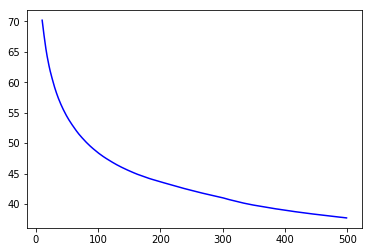

In [22]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

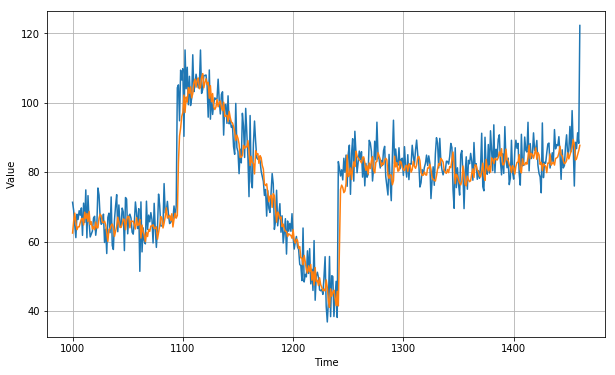

In [23]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.886353